<a href="https://colab.research.google.com/github/Pisarenkova/KT_2025/blob/main/%22fenics_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [ ]:
!apt-get install -y software-properties-common
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update
!apt-get install -y fenics

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Repository: 'deb https://ppa.launchpadcontent.net/fenics-packages/fenics/ubuntu/ jammy main'
Description:
This PPA provides packages for the FEniCS project (https://fenicsproject.org).
More info: https://launchpad.net/~fenics-packages/+archive/ubuntu/fenics
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-jammy.list
Adding key to /etc/apt/trusted.gpg.d/fenics-packages-ubuntu-fenics.gpg with fingerprint 6C1DA1C0EC4B649179C1C7437C3297BD11D01687
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-update

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2025-03-21 16:24:02--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.111.153, 185.199.110.153, 185.199.109.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-03-21 16:24:02 (27.0 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1f33a7ab/releases/pybi

# Решение задачи

In [3]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

# Определяем сетку

# def create_mesh(h):
#     return UnitSquareMesh(int(np.pi/h), int(np.pi/h))

def create_mesh(h):
    # Определяем углы прямоугольника
    p0 = Point(0.0, 0.0)  # Нижний левый угол
    p1 = Point(np.pi, np.pi)  # Верхний правый угол

    # Создаем сетку с заданным шагом h
    return RectangleMesh(p0, p1, int(np.pi/h), int(np.pi/h))


# Основная функция для численного решения
def solve_pde(f_exp, u_d, h):
    mesh = create_mesh(h)
    V = FunctionSpace(mesh, 'P', 1)  # Пространство функций первого порядка

    # Граничные условия
    u_D = Expression(u_d, degree=2)
    bc = DirichletBC(V, u_D, 'on_boundary')

    # Определяем вариационную форму
    u = TrialFunction(V)
    v = TestFunction(V)
    f_expr = Expression(f_exp, degree=2)
    print(f_expr)
    a = inner(nabla_grad(u), nabla_grad(v)) * dx
    L = f_expr * v * dx

    # Решаем задачу
    u = Function(V)
    solve(a == L, u, bc)

    return mesh, u

f_839


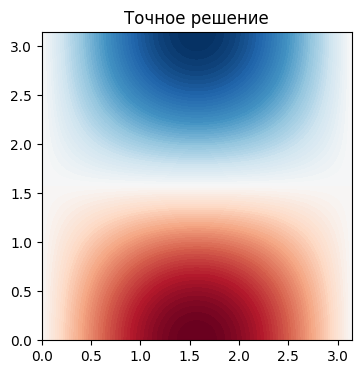

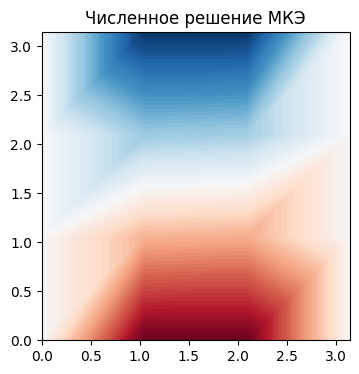

f_891


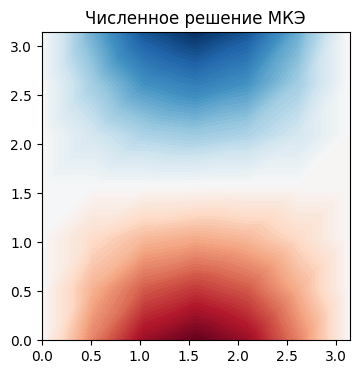

f_943


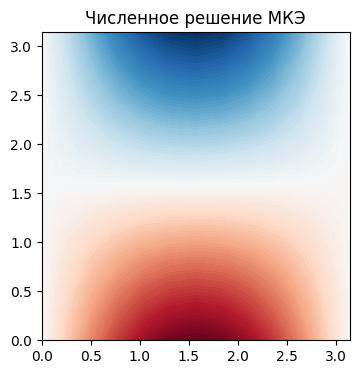

f_995


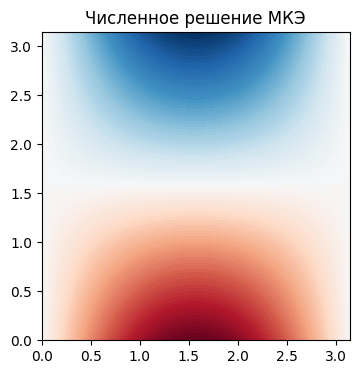

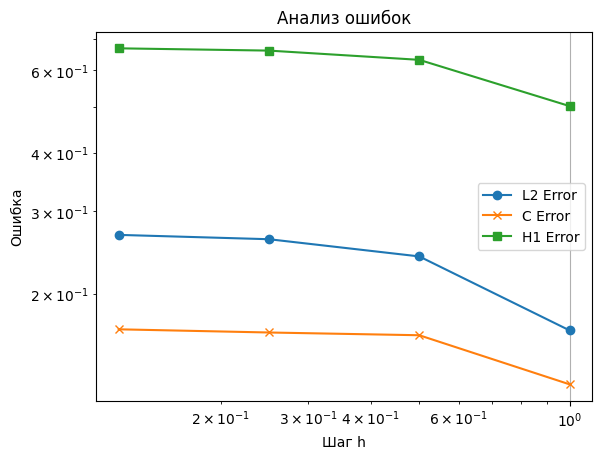

In [8]:
# Определяем функцию f
def f(x, y):
    return np.sin(x) * np.cos(y)

 # Точное решение
def exact_solution(x, y):
    return np.sin(x) * np.cos(y)

 # Визуализация точного решения
plt.figure(figsize=(4, 4))

x = np.linspace(0, np.pi, 100)
y = np.linspace(0, np.pi, 100)

# x = np.linspace(0, 1, 100)
# y = np.linspace(0, 1, 100)

X, Y = np.meshgrid(x, y)
Z_exact = exact_solution(X, Y)
plt.contourf(X, Y, Z_exact, levels=100, cmap='RdBu_r')
plt.title('Точное решение')

# Визуализация
def plot_solutions(mesh, numerical_solution):
    plt.figure(figsize=(4, 4))

    # Визуализация численного решения
    plot(numerical_solution, title='Численное решение МКЭ', levels=100, cmap='RdBu_r')


    # Визуализация разности
    #Z_numerical = np.array([numerical_solution(x, y) for x in X.flatten() for y in Y.flatten()]).reshape(X.shape)
    #Z_diff = np.abs(Z_numerical - Z_exact)
    #plt.figure()
    #plt.contourf(X, Y, Z_diff, levels=50)
    #plt.title('Difference |Numerical - Exact|')
    #plt.colorbar()
    plt.show()

#plot_solutions(mesh, numerical_solution)
#plot_solutions(mesh,)

# Основной цикл для анализа зависимости от h
h_values = [1, 0.5, 0.25, 0.125]
errors_L2 = []
errors_C = []
errors_H1 = []

for h in h_values:
    mesh, numerical_solution = solve_pde('sin(x[0])*cos(x[1])','sin(x[0])*cos(x[1])', h)

    plot_solutions(mesh, numerical_solution)

    # Вычисление ошибок
    exact_sol = interpolate(Expression('sin(x[0])*cos(x[1])', degree=2), numerical_solution.function_space())
    error_L2 = errornorm(exact_sol, numerical_solution, 'L2')
    error_C = np.max(np.abs(numerical_solution.vector().get_local() - exact_sol.vector().get_local()))
    error_H1 = errornorm(exact_sol, numerical_solution, 'H1')

    errors_L2.append(error_L2)
    errors_C.append(error_C)
    errors_H1.append(error_H1)


# Визуализация зависимости ошибок от h
plt.figure()
plt.loglog(h_values, errors_L2, label='L2 Error', marker='o')
plt.loglog(h_values, errors_C, label='C Error', marker='x')
plt.loglog(h_values, errors_H1, label='H1 Error', marker='s')
plt.xlabel('Шаг h')
plt.ylabel('Ошибка')
plt.title('Анализ ошибок')
plt.legend()
plt.grid()
plt.show()

f(x,y)=sin(x)cos(5y)

f_215


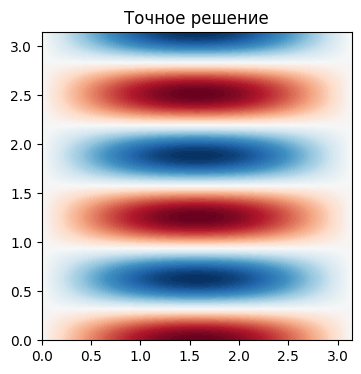

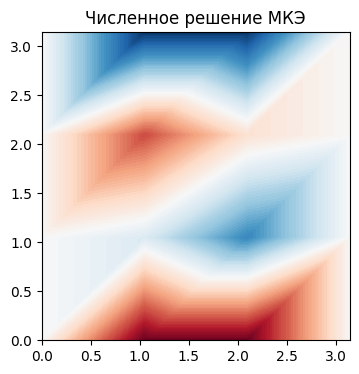

f_267


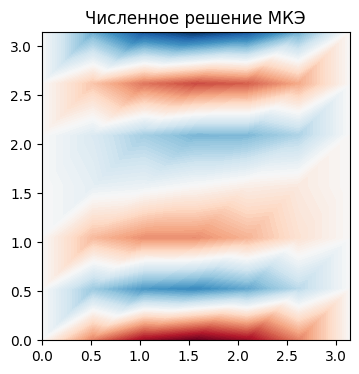

f_319


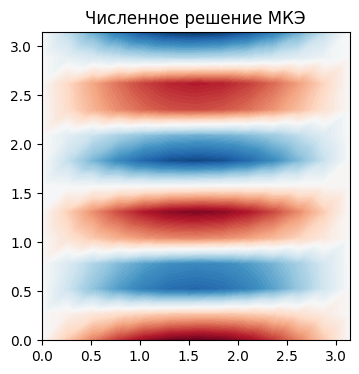

f_371


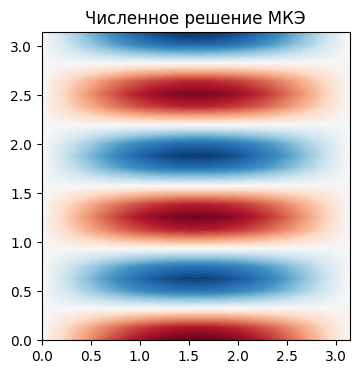

f_423


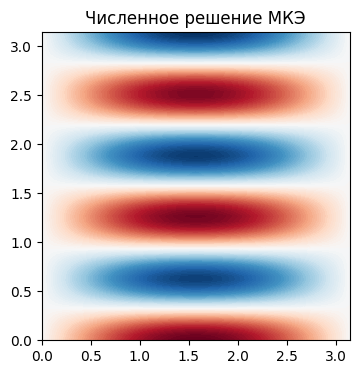

f_475


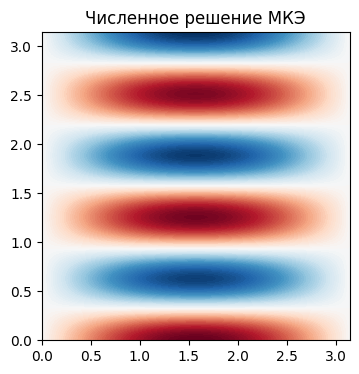

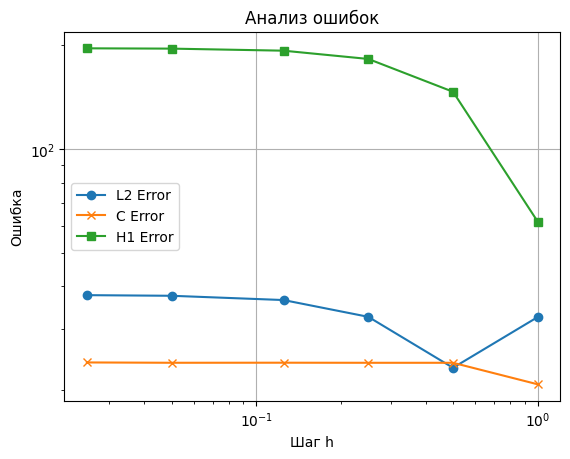

In [6]:
# Определяем функцию f
def f(x, y):
    return -25 * np.sin(x) * np.cos(5*y)

 # Точное решение
def exact_solution(x, y):
    return np.sin(x) * np.cos(5*y)

 # Визуализация точного решения
plt.figure(figsize=(4, 4))

x = np.linspace(0, np.pi, 100)
y = np.linspace(0, np.pi, 100)

# x = np.linspace(0, 1, 100)
# y = np.linspace(0, 1, 100)

X, Y = np.meshgrid(x, y)
Z_exact = exact_solution(X, Y)
plt.contourf(X, Y, Z_exact, levels=100, cmap='RdBu_r')
plt.title('Точное решение')

# Визуализация
def plot_solutions(mesh, numerical_solution):
    plt.figure(figsize=(4, 4))

    # Визуализация численного решения
    plot(numerical_solution, title='Численное решение МКЭ', levels=100, cmap='RdBu_r')
    plt.show()

#plot_solutions(mesh, numerical_solution)
#plot_solutions(mesh,)

# Основной цикл для анализа зависимости от h
h_values = [1, 0.5, 0.25, 0.125, 0.05, 0.025]
errors_L2 = []
errors_C = []
errors_H1 = []

#mesh, numerical_solution = solve_pde('25*sin(x[0])*cos(5*x[1])',h=h_values[3])
#plot_solutions(mesh, numerical_solution)


for h in h_values:
    mesh, numerical_solution = solve_pde('25*sin(x[0])*cos(5*x[1])','sin(x[0])*cos(5*x[1])',h)

    plot_solutions(mesh, numerical_solution)

    # Вычисление ошибок
    exact_sol = interpolate(Expression('25*sin(x[0])*cos(5*x[1])', degree=2), numerical_solution.function_space())
    error_L2 = errornorm(exact_sol, numerical_solution, 'L2')
    error_C = np.max(np.abs(numerical_solution.vector().get_local() - exact_sol.vector().get_local()))
    error_H1 = errornorm(exact_sol, numerical_solution, 'H1')

    errors_L2.append(error_L2)
    errors_C.append(error_C)
    errors_H1.append(error_H1)


# Визуализация зависимости ошибок от h
plt.figure()
plt.loglog(h_values, errors_L2, label='L2 Error', marker='o')
plt.loglog(h_values, errors_C, label='C Error', marker='x')
plt.loglog(h_values, errors_H1, label='H1 Error', marker='s')
plt.xlabel('Шаг h')
plt.ylabel('Ошибка')
plt.title('Анализ ошибок')
plt.legend()
plt.grid()
plt.show()

f(x,y)=sin(3x)cos(3x)

f_527


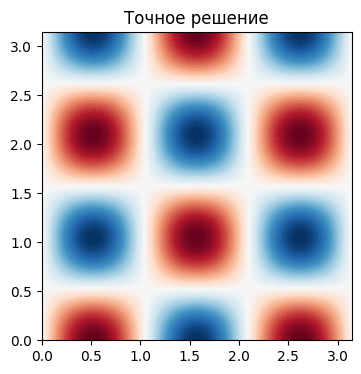

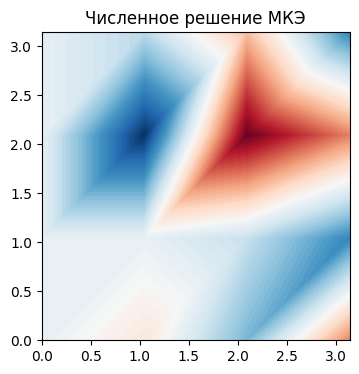

f_579


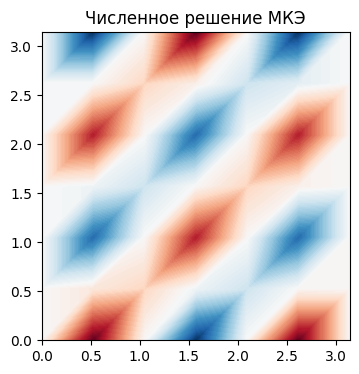

f_631


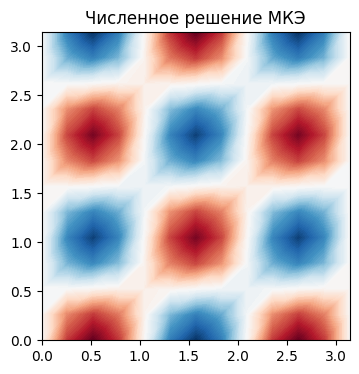

f_683


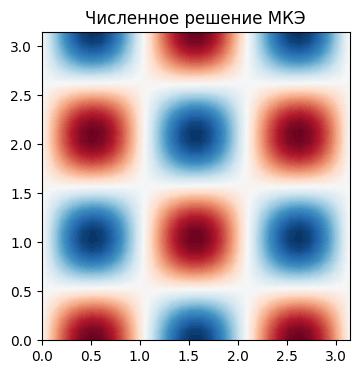

f_735


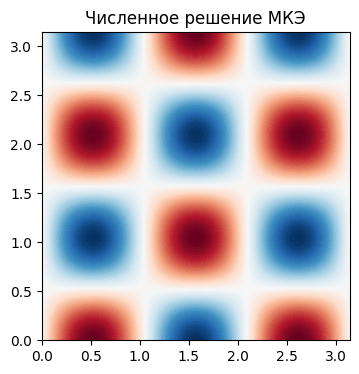

f_787


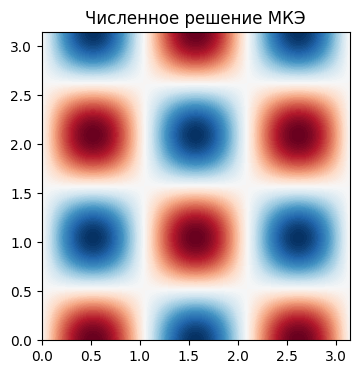

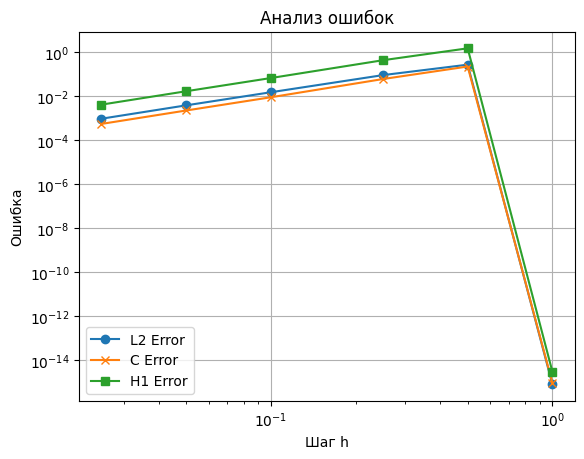

In [7]:
#  # Определяем функцию f
# def f(x, y):
#     return np.sin(3*x) * np.cos(3*y)

 # Точное решение
def exact_solution(x, y):
    return np.sin(3*x) * np.cos(3*y)

 # Визуализация точного решения
plt.figure(figsize=(4, 4))

x = np.linspace(0, np.pi, 100)
y = np.linspace(0, np.pi, 100)

# x = np.linspace(0, 1, 100)
# y = np.linspace(0, 1, 100)

X, Y = np.meshgrid(x, y)
Z_exact = exact_solution(X, Y)
plt.contourf(X, Y, Z_exact, levels=100, cmap='RdBu_r')
plt.title('Точное решение')

# Визуализация
def plot_solutions(mesh, numerical_solution):
    plt.figure(figsize=(4, 4))

    # Визуализация численного решения
    plot(numerical_solution, title='Численное решение МКЭ', levels=100, cmap='RdBu_r')


    # Визуализация разности
    #Z_numerical = np.array([numerical_solution(x, y) for x in X.flatten() for y in Y.flatten()]).reshape(X.shape)
    #Z_diff = np.abs(Z_numerical - Z_exact)
    #plt.figure()
    #plt.contourf(X, Y, Z_diff, levels=50)
    #plt.title('Difference |Numerical - Exact|')
    #plt.colorbar()
    plt.show()

#plot_solutions(mesh, numerical_solution)
#plot_solutions(mesh,)

# Основной цикл для анализа зависимости от h
h_values = [1, 0.5, 0.25, 0.1, 0.05, 0.025]
errors_L2 = []
errors_C = []
errors_H1 = []

for h in h_values:
    mesh, numerical_solution = solve_pde('18*sin(3*x[0])*cos(3*x[1])','sin(3*x[0])*cos(3*x[1])', h)

    plot_solutions(mesh, numerical_solution)

    # Вычисление ошибок
    exact_sol = interpolate(Expression('sin(3*x[0])*cos(3*x[1])', degree=2), numerical_solution.function_space())
    error_L2 = errornorm(exact_sol, numerical_solution, 'L2')
    error_C = np.max(np.abs(numerical_solution.vector().get_local() - exact_sol.vector().get_local()))
    error_H1 = errornorm(exact_sol, numerical_solution, 'H1')

    errors_L2.append(error_L2)
    errors_C.append(error_C)
    errors_H1.append(error_H1)


# Визуализация зависимости ошибок от h
plt.figure()
plt.loglog(h_values, errors_L2, label='L2 Error', marker='o')
plt.loglog(h_values, errors_C, label='C Error', marker='x')
plt.loglog(h_values, errors_H1, label='H1 Error', marker='s')
plt.xlabel('Шаг h')
plt.ylabel('Ошибка')
plt.title('Анализ ошибок')
plt.legend()
plt.grid()
plt.show()

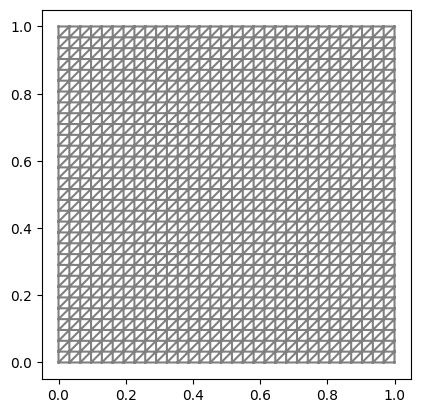

In [ ]:
def create_mesh(h):
    return UnitSquareMesh(int(np.pi/h), int(np.pi/h))

h = 0.1  # Пример значения h
mesh = create_mesh(h)

# Визуализация сетки
plot(mesh)
plt.show()


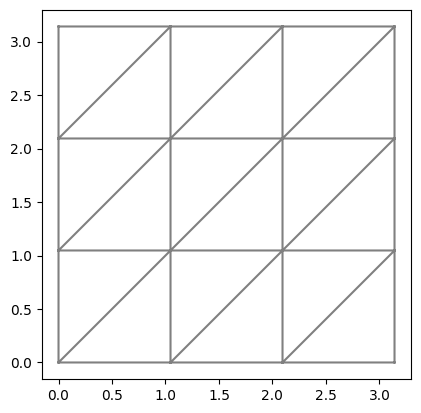

In [ ]:
def create_mesh(h):
    # Определяем углы прямоугольника
    p0 = Point(0.0, 0.0)  # Нижний левый угол
    p1 = Point(np.pi, np.pi)  # Верхний правый угол

    # Создаем сетку с заданным шагом h
    return RectangleMesh(p0, p1, int(np.pi/h), int(np.pi/h))

h = 1  # Пример значения h
mesh = create_mesh(h)

# Визуализация сетки
plot(mesh)
plt.show()